<h1><center>
    Implementing, fine-tuning and visualizing transformer architectures. <br/>
  
    
    Project 1
</center></h1>

<h3>Contributors</h3>
<dev>
<li>Eric Egli, 15-705-411</li>
<li>Kirat Virmani, 22-738-538</li>
<li>Diana Alexandra Dragos, 21-742-648</li>
<li>Abdlrahman Essa, 20-752-663</li>
<li>Hasan Atak, 20-751-897</li>
</dev>

# Task 1

Implement the feed-forward pass of the original transformer network using only numpy, i.e. without machine learning frameworks.

Note: All subtasks are voluntary and rather a guide-line of how we would implement the forward pass. You can also choose a different order for implementing the different parts or implement everything in one class/function. The forward pass should return an numpy array.

Please initialize the weights using Glorot initialization.


In [ ]:
# You will test your implementation on a single array:
from enum import Enum
import numpy as np
from numpy.typing import NDArray
from typing import Any, Optional, Callable
from abc import ABC, abstractmethod


np.random.seed(8)

forward_pass_array = np.array([101, 400, 500, 600, 107, 102])

In [ ]:
VOCAB_SIZE = 2048
MAX_SEQ_LEN = 2048

CLS_TOKEN = 0

D_MODEL = 512
FF_SIZE = 2048
DROPOUT_RATE = 0.1

N_ENCODERS = 6
N_DECODERS = 6
N_MHA_HEADS = 8


## Task 1.1

Implement the sinus/cosinus positional encoding used in the original paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Implement the token embedding.


In [ ]:
# TODO: Glorot initialization

In [ ]:
class Module(ABC):
    def __call__(self, *args: Any, **kwargs: Any) -> Any:
        return self.forward(*args, **kwargs)

    @abstractmethod
    def forward(self) -> NDArray:
        pass

In [ ]:
class TokenEmbedder(Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=D_MODEL):
        self.vocab_size = vocab_size
        self.embedding = np.random.randn(vocab_size, d_model)

    def forward(self, x: NDArray[np.int32]):
        if (max_arg := np.max(x)) > self.vocab_size:
            raise ValueError(
                f"Token {max_arg} is greater than vocabulary of size {self.vocab_size}"
            )
        return self.embedding[x]


class PositionalEncoder(Module):
    def __init__(self, d_model=D_MODEL, max_len=MAX_SEQ_LEN):
        self.max_len = max_len
        self.pe = np.zeros((max_len, d_model), dtype=np.float64)
        for pos in range(max_len):
            for i in range(d_model):
                if i % 2 == 0:
                    self.pe[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    self.pe[pos, i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

    # x is a sequence of tokens
    def forward(self, x: NDArray[np.int32]):
        seq_len = x.shape[0]
        assert (
            seq_len <= self.max_len
        ), f"Sequence length {seq_len} is greater than the maximum sequence length {self.max_len}"
        return x + self.pe[:seq_len]

## Task 1.2

Implement a dense layer with the number of hidden units as an argument.


In [ ]:
# Inspo and explanation:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

# The number of hidden units is equal to the number of output
# features. The API for this module is inspired by torch.nn.Linear
# rather than tf.keras.layers.Dense where the input dims are inferred
# within a sequential model
class Dense(Module):
    def __init__(self, in_features: int, out_features: int):
        self.W = np.random.randn(in_features, out_features)
        self.b = np.random.randn(out_features)

    def forward(self, x: NDArray):
        return np.matmul(x, self.W) + self.b

## Task 1.3

Implement all activation function such that they are compatible with the dense layer.


In [ ]:
class Activation:
    @staticmethod
    def ReLU(x: NDArray):
        return np.maximum(0, x)

## Task 1.5

Implement layer normalization.


In [ ]:
# Inspo and explanation:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization
# https://arxiv.org/pdf/1607.06450.pdf

# With Layer Normalization the normalization happens across the axes
# within each example, rather than across different examples in the
# batch. Layer normalization performs exactly the same computation at
# training and test times
class LayerNorm(Module):
    def __init__(self, d_model=D_MODEL):
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
        self.eps = 1e-6

    def forward(self, x: NDArray):
        # Mean and var across the last axis (embedding dimension)
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        x_norm = self.gamma * (x - mean) / np.sqrt(var + self.eps) + self.beta
        return x_norm

## Task 1.6

Implement dropout.


In [ ]:
class Dropout(Module):
    def __init__(self, dropout_rate=DROPOUT_RATE):
        self.dropout_rate = dropout_rate

    def forward(self, x: NDArray):
        mask = np.random.binomial(1, self.dropout_rate, size=x.shape)
        return x * mask

## Task 1.4

Implement the skip (residual) connections.


In [ ]:
class ResidualConnection(Module):
    # "We employ a residual connection around each of the two
    # sub-layers, followed by layer normalization. The output of each
    # sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is
    # the function implemented by the sub-layer itself"
    def __init__(self, dropout_rate=DROPOUT_RATE, d_model=D_MODEL):
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNorm(d_model)

    def forward(self, x: NDArray, sublayer: Callable[[NDArray], NDArray]):
        return x + self.dropout(sublayer(self.layer_norm(x)))

## Task 1.7

Implement the attention mechanism.


In [ ]:
class Utils:
    @staticmethod
    def softmax_stable(x: NDArray):
        # Subtract max to avoid overflow
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        return numerator / denominator

In [ ]:
class Attention:
    @staticmethod
    def score(query: NDArray, key: NDArray, value: NDArray, mask_index: Optional[int] = None):
        # Input dimensions: [8, Tx, 64]

        # Grab embedding dimension [64]
        d_k = query.shape[-1]

        # Swap the last two axes: [8, Tx, 64] -> [8, 64, Tx]
        # This is equivalent to transposing the the inner matrices
        key_t = key.swapaxes(-2, -1)

        # Attention is calculated across rows. Each row is one head
        # holding its corresponding keys and queries. With 3D tensors
        # and np.matmul, only the two last dimensions are multiplied.
        # [8, Tx, 64] @ [8, 64, Tx] -> [8, Tx, Tx] This gives the
        # compatibility between each query and key, or the attention
        # score between elements in the sequence
        kv_score = np.matmul(query, key_t) / np.sqrt(d_k)

        # Masking: Not used in our implementation since this is
        # inference mode but by passing an index, future tokens could
        # be masked in training mode
        if mask_index is not None:
            
            # we apply a triangular matrix where all the entries above
            # the (offset) diagonal are set to True mask ensures that
            # each query attends to itself and prev keys and no future
            # keys are leaked the mask_index specifies the index
            # (diagonal offset) from which the masking is applied.
            # this is necessary when we have a fixed-length target
            # sequence during training. note that, in our case, we do
            # not have a fixed-length output sequence (as noted during
            # the office hours). how index works: e.g., if mask_index
            # is 1, then the first token can only attend to itself. if
            # mask_index is 2, the first two tokens can attend to
            # themselve
            seq_len = kv_score.shape[-1]
            mask = np.tril(np.full((seq_len, seq_len), True, dtype=bool), k=mask_index-seq_len)
            mask = np.invert(mask)
            
            # Set all scores that belong to a masked connection to a very
            # large negative number. This will ensure that when softmaxed,
            # they will be near zero, effectively dropping them out.
            kv_score = np.where(mask, np.full_like(kv_score, -1e9), kv_score)
            

        # Softmax over the last axis
        weights = Utils.softmax_stable(kv_score)
        return np.matmul(weights, value)  # [8, Tx, 64]


class MultiHeadAttention(Module):
    def __init__(self, n_heads=N_MHA_HEADS, d_model=D_MODEL) -> None:
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_k = d_model // n_heads
        self.d_v = self.d_k  # As in the original paper
        self.n_heads = n_heads

        # Weight matrices are shared per head. Each head owns a slice
        # of size (d_model) x (d_k)
        self.W_q = Dense(d_model, d_model)  # [512, 512]
        self.W_k = Dense(d_model, d_model)  # [512, 512]
        self.W_v = Dense(d_model, d_model)  # [512, 512]
        self.W_o = Dense(d_model, d_model)  # [512, 512]

    # Although, in self attention, queries, keys and values are all
    # the same, we must accept different parameters because they're
    # not the same in encoder-decoder attention. Shapes: [Tx, 512]

    def forward(
        self, queries: NDArray, keys: NDArray, values: NDArray, mask_index: Optional[int]
    ):
        # 1. w(x): Linearly project the queries, keys and values:  We
        #    do this once for all heads that share the same matrix.
        #    Dimensions for q,k,v are preserved: [Tx, 512]
        # 2. reshape(): In order to calculate attention on a per-head
        #    basis, we need to reshape and add an explicit head
        #    dimension. In the constructor, we assert that d_model can
        #    be divided evenly by the number of heads. This will split
        #    the second dimension d_model into n_heads * d_k. New
        #    dimensions: [Tx, 8, 64]
        # 3. transpose(): In order to calculate attention on a
        #    per-head basis, we need to swap the first two dimension
        #    from [Tx, 8, 64] to [8, Tx, 64]. When we pass this to the
        #    attention function, attention is calculated across rows,
        #    which means for each head. New dims: [8, Tx, 64]
        #
        # This allows us to operate on a single matrix that is shared
        # among heads
        queries, keys, values = [
            # Let numpy infer the sequence length
            w(x).reshape(-1, self.n_heads, self.d_k).swapaxes(0, 1)
            for w, x in zip((self.W_q, self.W_k, self.W_v), (queries, keys, values))
        ]

       


        # Calculate attention in one go: [8, Tx, 64] for all params
        x = Attention.score(queries, keys, values, mask_index)

        # Reverse the above operation: [8, Tx, 64] -> [Tx, 8, 64] ->
        # [Tx, 512]
        x = x.swapaxes(0, 1).reshape(-1, self.n_heads * self.d_k)

        # Final linear projection
        return self.W_o(x)

## Task 1.8

Implement the positonal feed-forward network.


In [ ]:
class FeedForward(Module):
    def __init__(self, d_model=D_MODEL, d_ff=FF_SIZE):
        self.W_1 = Dense(d_model, d_ff)
        self.W_2 = Dense(d_ff, d_model)

    def forward(self, x: NDArray):
        return self.W_2(Activation.ReLU(self.W_1(x)))

## Task 1.9

Implement the encoder attention.


## Task 1.10

Implement the encoder.


In [ ]:
class EncoderLayer(Module):
    """A single encoder layer"""

    def __init__(
        self,
        n_heads=N_MHA_HEADS,
        d_model=D_MODEL,
        d_ff=FF_SIZE,
        dropout_rate=DROPOUT_RATE,
    ):
        self.sublayers = [
            ResidualConnection(dropout_rate=dropout_rate, d_model=d_model),
            ResidualConnection(dropout_rate=dropout_rate, d_model=d_model),
        ]
        self.self_attention = MultiHeadAttention(n_heads=n_heads, d_model=d_model)
        self.ff = FeedForward(d_model=d_model, d_ff=d_ff)

    def forward(self, x: NDArray):
        # Send through first sublayer: Self attention and residual
        # connection
        x = self.sublayers[0](x, lambda x: self.self_attention(x, x, x, None))
        # Send through second sublayer: Feed-forward and residual
        # connection
        x = self.sublayers[1](x, lambda x: self.ff(x))
        return x

In [ ]:
class Encoder(Module):
    """ A stack of encoder layers """
    def __init__(
        self,
        n_encoders=N_ENCODERS,
        n_heads=N_MHA_HEADS,
        d_model=D_MODEL,
        d_ff=FF_SIZE,
        dropout_rate=DROPOUT_RATE,
    ):
        self.dropout = Dropout(dropout_rate=dropout_rate)
        self.encoders = [
            EncoderLayer(
                n_heads=n_heads, d_model=d_model, d_ff=d_ff, dropout_rate=dropout_rate
            )
            for _ in range(n_encoders)
        ]

    def forward(self, x: NDArray):
        # "We apply dropout to the sums of the embeddings and the
        # positional encodings in both the encoder and decoder stacks"
        x = self.dropout(x)
        for encoder in self.encoders:
            x = encoder(x)
        return x

## Task 1.11

Implement the decoder attention.


## Task 1.12

Implement the encoder-decoder attention.


## Task 1.13

Implement the decoder.


In [ ]:
class DecoderLayer(Module):
    def __init__(
        self,
        n_heads=N_MHA_HEADS,
        d_model=D_MODEL,
        d_ff=FF_SIZE,
        dropout_rate=DROPOUT_RATE,
    ):
        self.sublayers = [
            ResidualConnection(dropout_rate=dropout_rate, d_model=d_model),
            ResidualConnection(dropout_rate=dropout_rate, d_model=d_model),
            ResidualConnection(dropout_rate=dropout_rate, d_model=d_model),
        ]
        self.self_attention = MultiHeadAttention(n_heads=n_heads, d_model=d_model)
        self.mh_attention = MultiHeadAttention(n_heads=n_heads, d_model=d_model)
        self.ff = FeedForward(d_model=d_model, d_ff=d_ff)

    def forward(self, x: NDArray, encoder_x: NDArray, mask_index: Optional[int] = None):
        # Send through first sublayer: Self attention and residual
        # connection

        x = self.sublayers[0](
            x,
            lambda x: self.self_attention(
                queries=x, keys=x, values=x, mask_index=mask_index
            ),
        )

        # Send through second sublayer: Multi-head attention and
        # residual connection. The query, which comes from the
        # decoder itself. The keys and values come from the encoder
        x = self.sublayers[1](
            x,
            lambda x: self.mh_attention(
                queries=x, keys=encoder_x, values=encoder_x, mask_index=mask_index
            ),
        )

        # Send through thrd sublayer: Feed-forward and residual
        # connection
        x = self.sublayers[2](x, lambda x: self.ff(x))
        return x

In [ ]:
class Decoder(Module):
    """A stack of decoder layers"""

    def __init__(
        self,
        n_decoders=N_DECODERS,
        n_heads=N_MHA_HEADS,
        d_model=D_MODEL,
        d_ff=FF_SIZE,
        dropout_rate=DROPOUT_RATE,
    ):
        self.dropout = Dropout(dropout_rate=dropout_rate)
        self.decoders = [
            DecoderLayer(
                n_heads=n_heads, d_model=d_model, d_ff=d_ff, dropout_rate=dropout_rate
            )
            for _ in range(n_decoders)
        ]

    def forward(
        self,
        x: NDArray,
        encoder_x: NDArray,
        mask_index: Optional[int],
    ):
        # "We apply dropout to the sums of the embeddings and the
        # positional encodings in both the encoder and decoder stacks"
        x = self.dropout(x)
        for decoder in self.decoders:
            x = decoder(x, encoder_x, mask_index)
        return x

## Task 1.14

Implement the transformer architecture (e.g. by creating a Transformer class that includes the steps before).


In [ ]:
class Predictor(Module):
    """ The final linear and softmax layer """
    def __init__(self, d_model=D_MODEL, vocab_size=VOCAB_SIZE):
        self.W = Dense(d_model, vocab_size)

    def forward(self, x: NDArray):
        return Utils.softmax_stable(self.W(x))

In [ ]:
class Transformer(Module):
    def __init__(
        self,
        n_encoders=N_ENCODERS,
        n_decoders=N_DECODERS,
        n_heads=N_MHA_HEADS,
        vocab_size=VOCAB_SIZE,
        d_model=D_MODEL,
        d_ff=FF_SIZE,
    ):
        self.input_embed = TokenEmbedder(vocab_size=vocab_size, d_model=d_model)
        self.target_embed = TokenEmbedder(vocab_size=vocab_size, d_model=d_model)
        self.pos_enc = PositionalEncoder(d_model=d_model, max_len=vocab_size)

        self.predictor = Predictor(d_model=d_model, vocab_size=vocab_size)

        self.encoder = Encoder(
            n_encoders=n_encoders, n_heads=n_heads, d_model=d_model, d_ff=d_ff
        )
        self.decoder = Decoder(
            n_decoders=n_decoders, n_heads=n_heads, d_model=d_model, d_ff=d_ff
        )

    # The very first input token should predict the first (shifted)
    # output token
    def forward(self, x: NDArray):
        # Input embeddings and positional encodings. We assume the
        # input sequence is already padded (hence, no masking here)
        x = self.input_embed(x)
        x = self.pos_enc(x)

        # Pass source through encoders
        x = self.encoder(x)

        # Output is shifted by one - the first output token is the CLS
        # token
        y = np.array([CLS_TOKEN])

        # Estimate 5 next tokens - this number can be anything since
        # we don't care about [SEP] tokens
        for _ in range(5):

            # Get target embeddings and positional encodings
            target_embedded = self.pos_enc(self.target_embed(y))

            # No masking since we're running in inference mode
            out = self.decoder.forward(x=target_embedded, encoder_x=x, mask_index=None)
            # Prob of next token given the last current token (size: vocab_size)
            probs = self.predictor(out[-1])

            next_token = np.argmax(probs)

            y = np.append(y, next_token)

        return y

## Task 1.15

Test the forward pass using the follow array.


In [ ]:
forward_pass_array = np.array([101, 400, 500, 600, 107, 102])
Transformer()(forward_pass_array)

array([   0, 1455,  344,  371, 1386, 1839])

# Task 2


In the following, we want to use pretrained models. From here on, you are allowed to use any machine learning frame work of your choice. Moreover, you will use [Hugging Face](https://huggingface.co/) which is compatible with tensorflow, keras, torch and other machine learning frameworks.

We want to fine-tune a pretrained model to determine whether Yelp reviews are positive or negative. The data set is available for [Tensorflow](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) and [(py)torch](https://pytorch.org/text/stable/datasets.html#yelpreviewpolarity). Given the text of a review, we want to determine whether the yelp review is positive and negative. The data set is pre-split into training and test set. Please use the training data to fine-tune your model, while using the test data to evaluate your models performance. This exercise does not necessarily end in having a SOTA model, the goal is for you to use and fine-tune SOTA pretrained large language models.

Problem Setting:

The label $y$ to a Yelp review $T$ is either positive or negative. Given a Yelp Review $T$ and a polarity feedback $y$ determine whether the Review $T$ is positive or negative. The training set $\mathcal{D} = \{(T_1, y_1), \ldots, (T_N, y_N)\}$, where $T_i$ is review $i$ and $y_i$ is $T_i$'s polarity feedback. A suitable evaluation metric for this type of problem is $\rightarrow$ see Theory Question 1.

In the following, please solve all subtasks.


## Theory Question 1

Which metric is threshold independent to evaluate the problem setting described in Task 2. Please list pros and cons of three different metrics that might be suitable, define an evaluation protocol and decide which evaluation suits this problem best.


The described problem is known as sentiment analysis in machine learning literature. The sentiment analysis task described in this assignment is a binary classification task. Therefore, we can make use of metrics which fit the classification task.

**Accuracy**

**Pros:**
Accuracy is a widely used and deployed classification metric in the data science community. A strength of the accuracy metric is its intuitiveness because of its 
simple calculation formula. 

**Cons:**
However, the accuracy metric can be misleading when working with skewed datasets. To illustrate this, lets take a dataset where 90% of the examples are positive reviews. It is possible to achieve 90% accuracy on this data by creating a model that always predicts a positive label, no matter what the input data looks like.


**AUC-ROC**

**Pros:**
With AUC-ROC it's possible to measure the quality of models in skewed datasets effectively. This makes AUC-ROC a powerful metric for binary classification tasks. Another advantage is the ability to plot the Receiver operating characteristic curve ("ROC" part of the AUC-ROC naming) visually with a graph.

**Cons:**
The formula for calculating AUC-ROC is not as simple and intuitive as the accuracy metric.


**Precision and Recall**

**Pros:**
Similarly to AUC-ROC, using precision and recall allows evaluating on skewed datasets. Both metrics can be combined into a single Metric with the $F_1$ score or, more generally, $F_\beta$ score. 

**Cons**:
Metric requires deeper inspection and is not intuitive.


**Final candidates**
We choose to use both the accuracy and AUC-ROC metrics. The reasons for choosing AUC-ROC over precision and recall is the possibility of visually plotting the score.



## Task 2.0

Load the Yelp Review Polarity dataset.


In [ ]:
# pip installations of libraries for the task
!pip install datasets transformers evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

In [ ]:
yelp_dataset = load_dataset('yelp_polarity')

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Task 2.1

Decide on a suitable language model from the HuggingFace model zoo (a library providing pretrained models).


In [ ]:
# bert was chosen for its compactness
# also recommended by the lecturers for convenient expir
MODEL = "bert-base-cased"

## Task 2.2

For the model to process the intended way, we need the tokenizer that was used during training. Luckily Hugging Face provides both pretrained models and tokenizer. After in Task 2.1 decided for a language model, please load the corresponding tokenizer.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

## Task 2.3

Load the language model from HuggingFace.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels= 2)
model.save_pretrained(MODEL)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Task 2.4

Fine-tune your model on the Yelp Review Polarity training data set. Note: If you have computational limitations consider fine-tuning only on part of the training dataset.

**Team Note**: The fine-tuning/training is executed in the next subtask

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = yelp_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/560000 [00:00<?, ? examples/s]

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
# tokenizing the dataset
# choosing  a small range for computational reasons
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))

In [ ]:
# Sample of dataset
print("Example text: " + small_train_dataset[0]["text"])
print("Label: " + str(small_train_dataset[0]["label"]))

Example text: Decent size, decent selection, decent staff.\n\nI guess that can wholly sum this place up, it's decent.  As with many other stores that are like this, the product rotates depending on what doesn't sale well at other stores.  Can always snag a deal here.  I was able to pick up a pretty sweet Puma jacket for $10, can't beat that, right?\n\nThat being said, there are those times that you may not find anything as well.  So really don't get your hopes up if you are looking for a specific item.
Label: 1


## Task 2.5

Evaluate your model, following the evaluation protocol you defined in Theory Question 1, on the test part of the Yelp Review Polarity data set.



**Note from team**
We train and evaluate the model at the same time through the `Trainer` class. That's why the previous subtask does not contain the `trainer.train()` (actual training) part.

In [ ]:
accuracy_metric = evaluate.load("accuracy")
aucroc_metric = evaluate.load("roc_auc")

# aucroc score expects probablities between 0 to 1 (positive)
# we use softmax to standardize the scores to that range for the positive class
def softmax_positive(input_logits):
    softmaxed_logits = np.exp(input_logits) / np.sum(np.exp(input_logits), axis=-1, keepdims=True)
    positive_logits = softmaxed_logits[:, 1]
    return positive_logits

# Custom function evaluating both accuracy and auc-roc
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # softmaxed score for aucroc
    softmax_logits = softmax_positive(logits)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    aucroc =  aucroc_metric.compute(prediction_scores=softmax_logits, references=labels)
    return {"accuracy": accuracy, "auc_roc": aucroc}

In [ ]:
# Training arguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# training the model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Auc Roc
1,0.274200,0.224133,{'accuracy': 0.9381},{'roc_auc': 0.9842873991029666}
2,0.125600,0.229440,{'accuracy': 0.9457},{'roc_auc': 0.9875603126176012}
3,0.029000,0.326187,{'accuracy': 0.9521},{'roc_auc': 0.9876778138208137}


Trainer is attempting to log a value of "{'accuracy': 0.9381}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'roc_auc': 0.9842873991029666}" of type <class 'dict'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9457}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'roc_auc': 0.9875603126176012}" of type <class 'dict'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9521}" of type <class 'dict'> for key "eval/accu

TrainOutput(global_step=3750, training_loss=0.15003342768351238, metrics={'train_runtime': 3961.0677, 'train_samples_per_second': 7.574, 'train_steps_per_second': 0.947, 'total_flos': 7893331660800000.0, 'train_loss': 0.15003342768351238, 'epoch': 3.0})

In [ ]:
# Sanity check of the model

# Example text for classification
inputs = "Very bad and cold food. Never come back. Good staff though"
encoding = tokenizer(inputs, return_tensors="pt")
# Remove the following line if you're not using a GPU to train
encoding.to('cuda')
with torch.no_grad():
    logits = model(**encoding).logits
predicted_class_id = logits.argmax().item()
print("Predicted Label for input: " + inputs)
print("positive" if predicted_class_id == "LABEL_1" else "negative")


Predicted Label for input: Very bad and cold food. Never come back. Good staff though
negative


In [ ]:
# Evaluation
results = trainer.predict(small_eval_dataset)
metrics = results.metrics
print(metrics["test_accuracy"])
print(metrics["test_auc_roc"])


**Final accuracy**: 0.95


**Final AUC-ROC**: 0.99

In [ ]:
def plot_auc_roc_curve(results):
  # aucroc score expects probablities between 0 to 1 (positive
  sft_preds = softmax_positive(results.predictions)
  lbls = results.label_ids

  fpr, tpr, thresholds = roc_curve(lbls, sft_preds)
  roc_auc = auc(fpr, tpr)

  # plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for \"bert-base-cased\" finetuned on the Yelp Polarity dataset')
  plt.legend(loc="lower right")

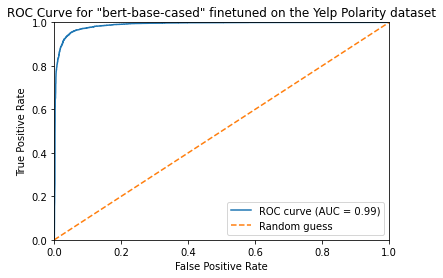

In [ ]:
plot_auc_roc_curve(results)

# Task 3

Visualize and interpret the attention weights of one correctly and one of the incorrectly classified examples of the Yelp Review Polarity test data using [BertViz](https://github.com/jessevig/bertviz)'s model_view.


In [ ]:
!pip install bertviz --quiet

In [ ]:
from bertviz import model_view
input_text = "Very good food. Will come back. Good staff."  
model.to('cuda')
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
inputs.to('cuda')
outputs = model(inputs.cuda(),output_attentions=True)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens) 

<IPython.core.display.Javascript object>

In [ ]:
predictions = results.predictions.tolist()
labels = results.label_ids.tolist()

In [ ]:
def get_view(input_text, tokenizer, model):
    inputs = tokenizer.encode(input_text, return_tensors='pt')
    inputs.to('cuda')
    outputs = model(inputs.cuda(), output_attentions=True)
    attention = outputs[-1]
    tokens = tokenizer.convert_ids_to_tokens(inputs[0])
    model_view(attention, tokens)
    return input_text

In [ ]:
# visualise incorrectly classified example
incorrect_index = None
for i in range(len(predictions)):
    if predictions[i] != labels[i] and len(small_eval_dataset[i]['text']) < 100:
        incorrect_index = i
        break

input_text = small_eval_dataset[incorrect_index]['text']
get_view(input_text, tokenizer, model)

<IPython.core.display.Javascript object>

'over rated, over priced and always crowded.'

Input text: "over rated, over priced and always crowded."

The attention weight view for this input text shows that the model is giving high attention to the words "over", "rated", "over", "priced", and "crowded", indicating that these are the most important words for determining the sentiment of the review. The attention weights for other words are relatively low, suggesting that they have less influence on the overall sentiment.

Input text: "Very good food. Will come back. Good staff."

The attention weight view for this input text shows that the model is giving high attention to the words "good" and "food", which are the most important words for determining the sentiment of the review. The model is also giving significant attention to the words "will", "come", and "back", indicating that the reviewer is likely to return to the restaurant. The attention weights for the other words are relatively low, indicating that they have less influence on the overall sentiment of the review.

## Theory Question 2

In your own words, describe how the attention mechanism in a transformer works in the case of self-attention and cross-attention, identifying in each case the keys, queries, and values. Give two examples of alignment models and describe how they affect the output using a simple example.

##### This part of the written report can be done in collaboration with your group.


##### The attention mechanism is a key component of the transofmer that allows the model to focus on different parts of the input sequence. When making predicitions.

When we talk about self-attention, we refer to a mechanism that is used in the transformer model which gives the model ability to weight it's own input sequence when making predictions. Self-attention is useful for capturing relationships between many NLP tasks as language modeling and machine translation. In self attention each word is represented by 3 vectors: a query vector, a key vector and a value vector. These vectors help compute what is known as the attention weight for each word in the input sequence.
Query vector is used to calculate the similarity between current word and all other words, the key vector represents the other words in the input sequence and is used to calculte the attention weights for earch word. The value vector is used to compute the weighted sum of the values of each word in the input sequence; these weights are determined by the similiarity between the query and key vectors. Mathematically, self-attention can be represented as follows:
Self-Attention(Q, K, V) = softmax(QK^T / sqrt(d_k))V
where Q, K, and V represent the query, key, and value vectors, respectively. The motivation of the softmax function is to to normalize the weights, while the dot product between the query and key vectors is divided by the square root of the dimensionality of the key vector (d_k) to prevent the problem of vanishing gradients. As a result we obtain the weighted sum of the values of each word in the input sequence, where these weights are determined by the similarity between the query and key vectors.

Cross-attention is used to deal with different sequence, mostly used in the case of machine translation. In cross-attention, there are two input sequences: the source sequence and the target sequence. The source sequence is typically the input sequence that the model is translating from, while the target sequence is the sequence that the model is translating to. Similar to the self-attention, each word is represented by the 3 vectors; query, key and value vectors. The query vector represents the current word being considered in the target sequence, the key vector represents all words in the source sequence, and the value vector represents the value associated with each source word. The attention weights are computed by comparing the query vector to the key vectors and are used to compute a weighted sum of the values of each source word.

Aligenment models in NLP are used to make sure one word from one language is mapped to the word with the exact same meaning in another language. They try to calculate the most probably (most likely) translation for each word of phrase in the first language.

##### 2 examples of the alignment models in NLP are

1- Hard alignment model is a deterministic approach. The idea is to try to map each word in the source sequence to a coressponding unique word in the target sequence. example: if we have the source sequence "I am happy" and the target sequence is the French equivalent "Je suis heureux", the hard alignment model would map "I" to "Je", "am" to "suis", and "happy" to "heureux".

2- The soft alignment model uses a probabilistic approach. The idea behind is is to try to determine the alignment between words in the source and target sequences. What that means is that we try to achieve a state where each source word is assigned a probability distribution over the target words, and the target word with the highest probability is chosen as the alignment. For example, in the same source and target sequences as the example from hard alignment, the soft alignment model might assign a high probability to "Je" for "I", but also assign non-zero probabilities to other words such as "Moi" or "On". This approach allows for more flexible alignments and can better capture the complexity of natural language.


# Task 4

Please describe your team's implementation of this project, including your personal contribution, in 1000-1500 characters. Each team member must explain the main aspects of the team's implementation, and may not discuss this summary with other students. You are allowed to use figures and tables to clarify. This summary constitutes a separately and individually graded piece of work.
